In [74]:
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#### Create a connection to database file

In [8]:
# Create a connection to a new or existing database file
connection = sqlite3.connect("tornado_tracks.db")

print("Connected:", connection)



Connected: <sqlite3.Connection object at 0x0000023007C4EE30>


#### Load tables from CSV files

In [66]:
weather_detail = pd.read_csv("../Datasets/Clean Files/weather_detail_cleaned.csv")
weather_detail.to_sql("weather_detail", connection, if_exists="replace", index=False)


17723

In [67]:
tornado_tracks = pd.read_csv("../Datasets/Clean Files/tornado_tracks_combined_cleaned.csv")
tornado_tracks.to_sql("tornado_tracks", connection, if_exists="replace", index=False)

530

#### Testing to make sure tables loaded

In [68]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", connection)

,name
0,weather_detail
1,tornado_tracks


In [ ]:
pd.read_sql("SELECT * FROM tornado_tracks ;", connection)

#### Joining both tables with an inner join.  28 row output

In [ ]:

Join = """
SELECT *
FROM tornado_tracks t
inner join weather_detail w
On t.Zip = w.Zip 
AND t.DATE = w.DATE

"""

df = pd.read_sql(Join, connection)
df

#### Count of Event type

In [10]:
event_type_count = """
SELECT event_type, COUNT(event_id) AS event_type
FROM tornado_tracks
GROUP BY event_type
ORDER BY event_type DESC
"""
df = pd.read_sql(event_type_count, connection)
df

,EVENT_TYPE,event_type
0,Thunderstorm Wind,404
1,Hail,101
2,Tornado,16
3,Heavy Rain,5
4,Lightning,4


In [6]:
## this function was created using help from Co Pilot

def get_event_stats(connection, event_type="Tornado", months=['06','07','08']):
    """
    Returns yearly counts of events and average temperature for a given event type and months.
    
    Parameters:
        connection : sqlite3.Connection
            Active database connection
        event_type : str
            Event type to filter (e.g., 'Tornado', 'Hail', 'Wind')
        months : list of str
            Months to filter (e.g., ['06','07','08'] for summer)
    
    Returns:
        DataFrame with columns: year, event_count, avg_temp
    """
    
    # Convert months list to SQL-friendly string
    month_filter = ",".join([f"'{m}'" for m in months])
    
    query = f"""
    WITH tornado AS (
        SELECT strftime('%Y', date) AS year,
               COUNT(DISTINCT event_id) AS event_count
        FROM tornado_tracks
        WHERE strftime('%m', date) IN ({month_filter})
          AND LOWER(TRIM(event_type)) = LOWER(TRIM('{event_type}'))
        GROUP BY year
    ),
    weather AS (
        SELECT strftime('%Y', date) AS year,
               AVG(tmax) AS avg_temp
        FROM weather_detail
        WHERE strftime('%m', date) IN ({month_filter})
        GROUP BY year
    )
    SELECT t.year, t.event_count, w.avg_temp
    FROM tornado t
    LEFT JOIN weather w ON t.year = w.year
    ORDER BY t.year;
    """
    
    return pd.read_sql(query, connection)



In [11]:
summer_tornados = get_event_stats(connection, event_type= "Tornado", months=['03','04','05','06','07'])
summer_tornados

,year,event_count,avg_temp
0,2015,1,75.458498
1,2017,1,76.912418
2,2018,2,75.328063
3,2019,1,74.748281
4,2022,1,76.630719
5,2023,4,74.568627
6,2024,4,77.360065
7,2025,2,76.919804


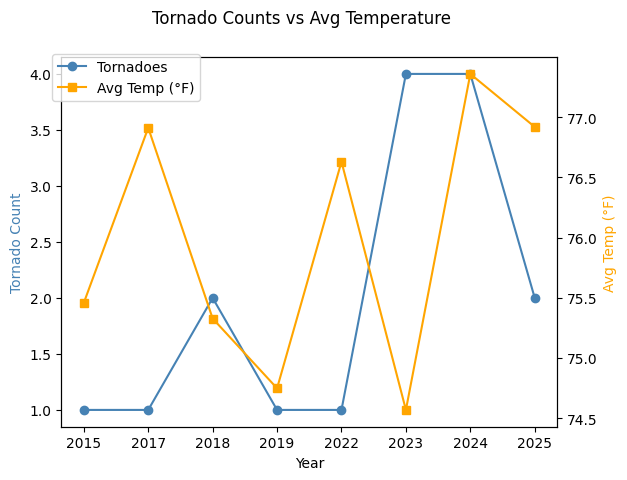

In [29]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # second y-axis

ax1.plot(summer_tornados["year"], summer_tornados["event_count"], marker="o", color="steelblue", label="Tornadoes")
ax2.plot(summer_tornados["year"], summer_tornados["avg_temp"], marker="s", color="orange", label="Avg Temp (°F)")

ax1.set_xlabel("Year")
ax1.set_ylabel("Tornado Count", color="steelblue")
ax2.set_ylabel("Avg Temp (°F)", color="orange")

fig.suptitle("Tornado Counts vs Avg Temperature")
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.xticks(rotation=45)
plt.show()




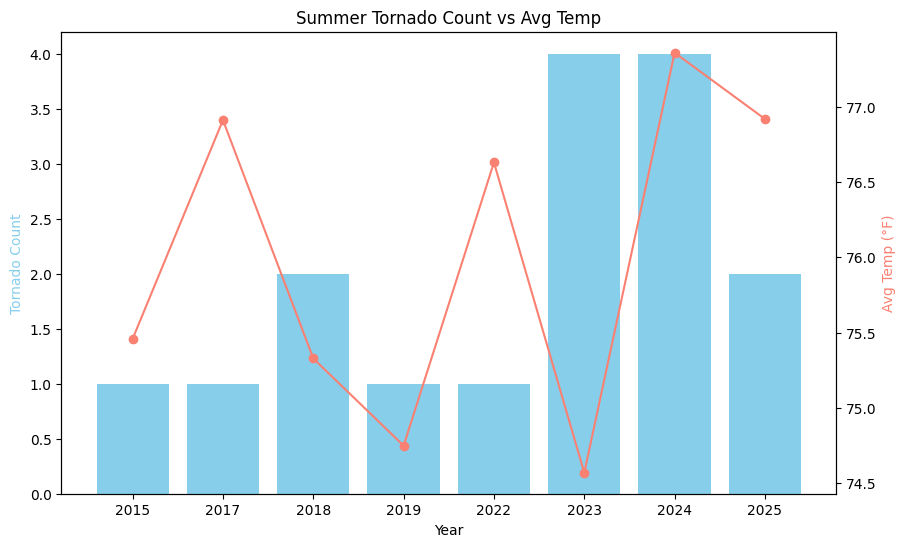

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

years = summer_tornados["year"]
tornado_counts = summer_tornados["event_count"]
avg_temps = summer_tornados["avg_temp"]

x = np.arange(len(years))  # positions for bars
width = 0.35               # bar width

# Tornado counts as bars
ax1.bar(years, tornado_counts, color="skyblue", label="Tornado Count")
ax1.set_xlabel("Year")
ax1.set_ylabel("Tornado Count", color="skyblue")

# Temperature on secondary axis
ax2 = ax1.twinx()
ax2.plot(years, avg_temps, color="salmon", marker="o", label="Avg Temp")
ax2.set_ylabel("Avg Temp (°F)", color="salmon")

plt.title("Summer Tornado Count vs Avg Temp")
plt.show()




In [16]:
temp = """
SELECT strftime('%Y', date) AS year, awnd, prcp, tmax
FROM weather_detail
GROUP BY year
ORDER BY year
"""
temp = pd.read_sql(temp , connection)
temp

,year,AWND,PRCP,TMAX
0,2015,8.05,0.00,40.0
1,2016,8.50,0.00,42.0
2,2017,3.36,0.02,49.0
3,2018,6.71,0.00,17.0
4,2019,4.47,0.00,54.0
5,2020,8.05,0.00,50.0
6,2021,9.62,1.04,65.0
7,2022,4.92,1.91,64.0
8,2023,2.91,0.00,56.0
9,2024,6.04,0.00,38.0


In [58]:
avg_temps='''
SELECT strftime('%Y', date) AS year,
       AVG(CASE WHEN strftime('%m', date) = '01' THEN tmax END) AS Jan,
       AVG(CASE WHEN strftime('%m', date) = '02' THEN tmax END) AS Feb,
       AVG(CASE WHEN strftime('%m', date) = '03' THEN tmax END) AS Mar,
       AVG(CASE WHEN strftime('%m', date) = '04' THEN tmax END) AS Apr,
       AVG(CASE WHEN strftime('%m', date) = '05' THEN tmax END) AS May,
       AVG(CASE WHEN strftime('%m', date) = '06' THEN tmax END) AS Jun,
       AVG(CASE WHEN strftime('%m', date) = '07' THEN tmax END) AS Jul,
       AVG(CASE WHEN strftime('%m', date) = '08' THEN tmax END) AS Aug,
       AVG(CASE WHEN strftime('%m', date) = '09' THEN tmax END) AS Sep,
       AVG(CASE WHEN strftime('%m', date) = '10' THEN tmax END) AS Oct,
       AVG(CASE WHEN strftime('%m', date) = '11' THEN tmax END) AS Nov,
       AVG(CASE WHEN strftime('%m', date) = '12' THEN tmax END) AS Dec
FROM weather_detail
GROUP BY year 
ORDER BY year DESC;
'''

avg_temps = pd.read_sql(avg_temps, connection)
avg_temps




,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2025,37.451613,47.750000,63.709677,70.116667,73.894309,86.250000,90.685484,85.695652,83.577778,86.000000,NaN,NaN
1,2024,40.201613,57.379310,62.317073,70.608333,79.532258,86.541667,87.758065,88.645161,83.025000,74.373984,60.512605,48.637097
2,2023,50.088710,56.053571,57.838710,69.525000,75.693548,82.175000,87.693548,85.894309,83.100840,70.512195,59.900000,52.201613
3,2022,40.693548,49.008929,61.669355,65.291667,79.306452,87.391667,89.475806,86.991935,81.150000,69.959350,57.883333,46.000000
4,2021,42.420000,39.946970,63.447368,67.740000,75.280000,85.566667,87.217742,88.790323,81.916667,72.862903,55.783333,59.088710
5,2020,48.738562,48.347222,61.784173,65.319728,73.771812,85.506757,90.000000,85.297297,79.965517,69.133333,62.384615,47.328671
6,2019,42.394737,51.463235,54.091503,70.577181,78.967320,82.812950,89.902256,88.157895,90.067114,72.748344,51.832168,51.973856
7,2018,40.520270,53.678832,54.025974,63.328859,84.409091,86.843537,88.083871,86.477124,82.155405,70.503268,50.986486,49.869281
8,2017,48.966887,58.451852,60.058065,74.453333,77.058065,84.793333,88.374194,84.980645,80.386667,70.535484,58.006803,45.203947
9,2016,42.853333,48.937063,62.728477,70.033333,73.915584,86.966216,88.109677,88.155844,84.693333,76.205298,63.643836,45.589404


In [61]:
avg_temps = avg_temps.fillna(0)
avg_temps_round = avg_temps.round(0).astype(int)

avg_temps_round



,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2025,37,48,64,70,74,86,91,86,84,86,0,0
1,2024,40,57,62,71,80,87,88,89,83,74,61,49
2,2023,50,56,58,70,76,82,88,86,83,71,60,52
3,2022,41,49,62,65,79,87,89,87,81,70,58,46
4,2021,42,40,63,68,75,86,87,89,82,73,56,59
5,2020,49,48,62,65,74,86,90,85,80,69,62,47
6,2019,42,51,54,71,79,83,90,88,90,73,52,52
7,2018,41,54,54,63,84,87,88,86,82,71,51,50
8,2017,49,58,60,74,77,85,88,85,80,71,58,45
9,2016,43,49,63,70,74,87,88,88,85,76,64,46


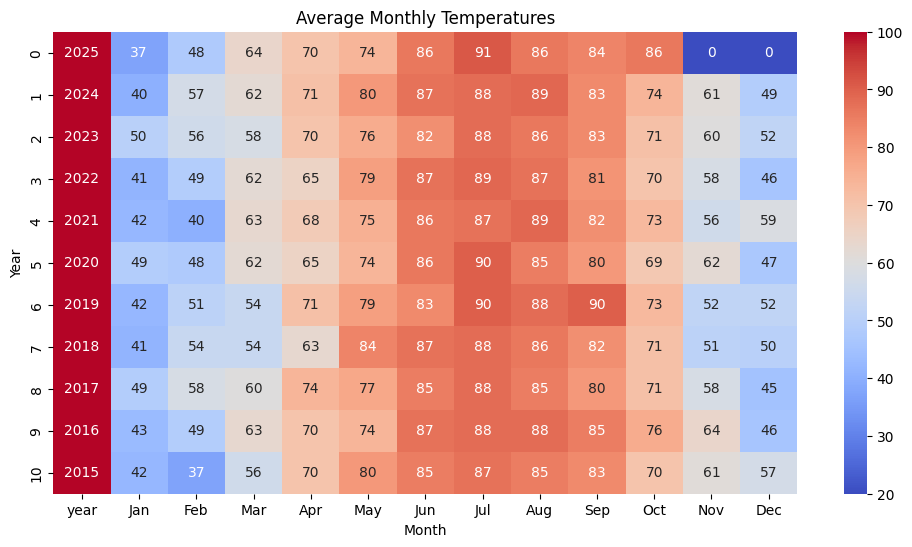

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(avg_temps_round, cmap="coolwarm", annot=True, fmt=".0f",
            vmin=20, vmax=100)   # adjust to climate range

plt.title("Average Monthly Temperatures")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


#### Close Connection

In [ ]:
# Always close your connection when you're done
connection.close()